# MRSI META Analysis Documentation
This notebook contains all the code required to reproduce the figures from the MRSI META analysis.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from contrastive import CPCA
import os

%matplotlib inline

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14

## Load Data

In [9]:
BACK = np.load('BACK.npy')
WMH = np.load('WMH.npy')
Labels = np.load('Labels.npy')
print(f"BACK shape: {BACK.shape}")
print(f"WMH shape: {WMH.shape}")

BACK shape: (162817, 1000)
WMH shape: (162, 1000)


## Figure 2C,D: Mean Spectra Comparison

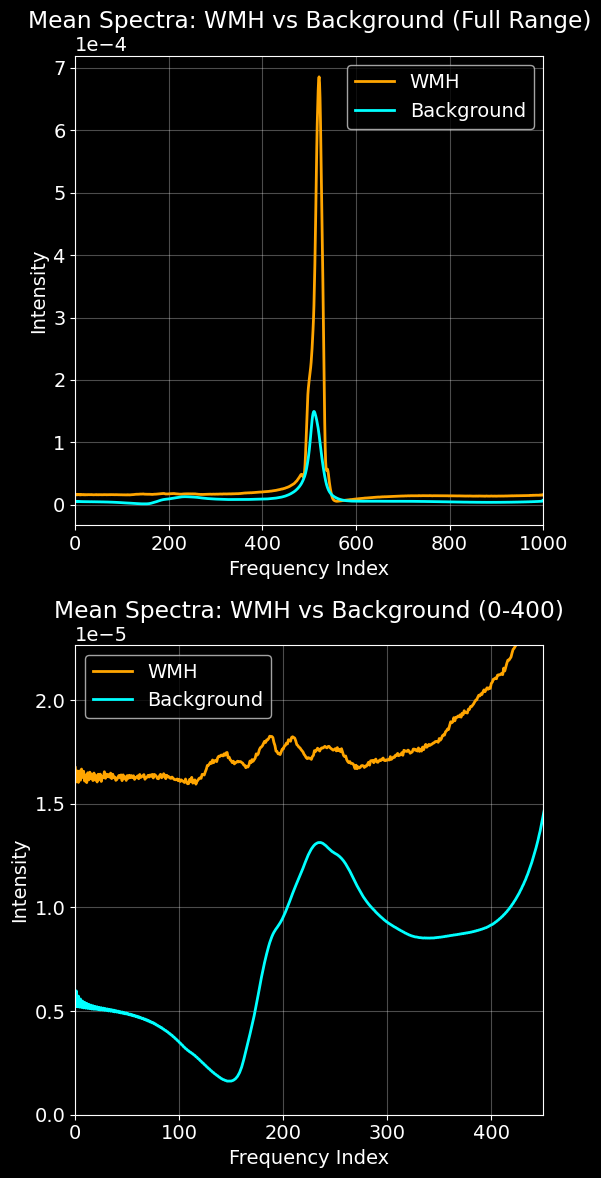

In [3]:
WMH_mean = np.mean(WMH, axis=0)
BACK_mean = np.mean(BACK, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(WMH_mean, color='orange', linewidth=2, label='WMH')
ax1.plot(BACK_mean, color='cyan', linewidth=2, label='Background')
ax1.set_title('Mean Spectra: WMH vs Background (Full Range)')
ax1.set_xlabel('Frequency Index')
ax1.set_ylabel('Intensity')
ax1.set_xlim(0, 1000)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(WMH_mean, color='orange', linewidth=2, label='WMH')
ax2.plot(BACK_mean, color='cyan', linewidth=2, label='Background')
ax2.set_title('Mean Spectra: WMH vs Background (0-400)')
ax2.set_xlabel('Frequency Index')
ax2.set_ylabel('Intensity')
ax2.set_xlim(0, 450)
ax2.set_ylim(0, np.max(WMH_mean[0:400])*1.1)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Figure 2A,B: PCA of All Spectra

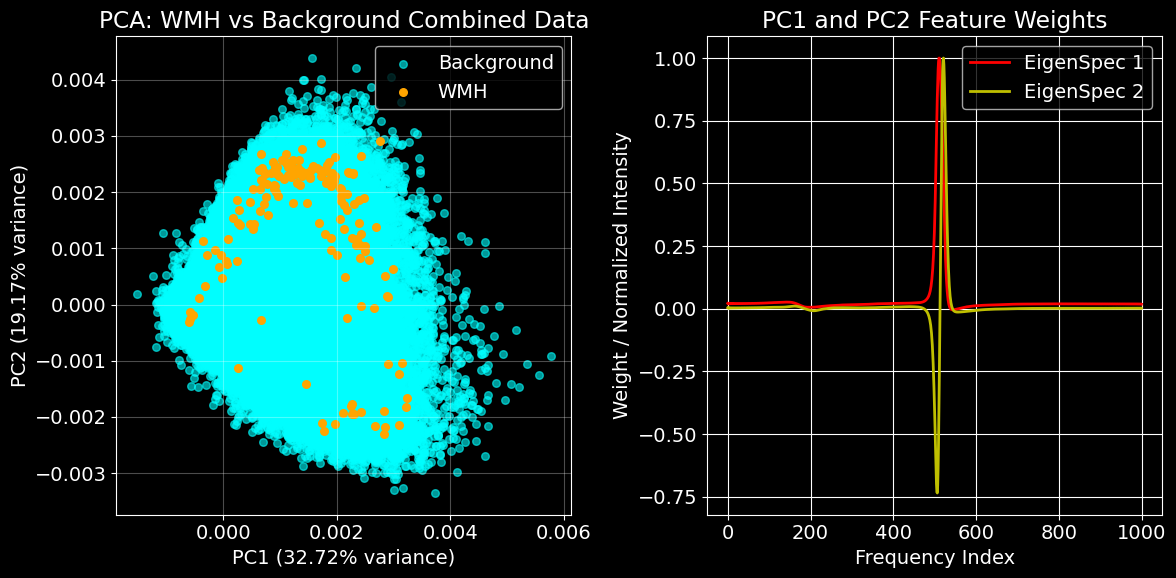

In [4]:
combined_data = np.concatenate([WMH, BACK], axis=0)
combined_labels = np.concatenate([np.ones(WMH.shape[0]), np.zeros(BACK.shape[0])])

pca_combined = PCA(n_components=2)
pca_combined_transformed = pca_combined.fit_transform(combined_data)

pca_components_combined = pca_combined.components_

for i in range(pca_components_combined.shape[0]):
    max_abs_value = np.max(np.abs(pca_components_combined[i, :]))
    if max_abs_value > 0:
        pca_components_combined[i, :] = pca_components_combined[i, :] / max_abs_value

wmh_indices = combined_labels == 1
back_indices = combined_labels == 0

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_combined_transformed[back_indices, 0], 
           pca_combined_transformed[back_indices, 1],
           c='cyan', label='Background', alpha=0.6, s=30)
plt.scatter(pca_combined_transformed[wmh_indices, 0], 
           pca_combined_transformed[wmh_indices, 1],
           c='orange', label='WMH', alpha=1.0, s=30)

explained_var_1 = pca_combined.explained_variance_ratio_[0] * 100
explained_var_2 = pca_combined.explained_variance_ratio_[1] * 100
plt.xlabel(f'PC1 ({explained_var_1:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_var_2:.2f}% variance)')
plt.title('PCA: WMH vs Background Combined Data')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(pca_components_combined[0, :], label=f'EigenSpec 1', linewidth=2, color='r')
plt.plot(pca_components_combined[1, :], label=f'EigenSpec 2', linewidth=2, color='y')
plt.title('PC1 and PC2 Feature Weights')
plt.xlabel('Frequency Index')
plt.ylabel('Weight / Normalized Intensity')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Figure 2C,D: PCA of WMH Spectra

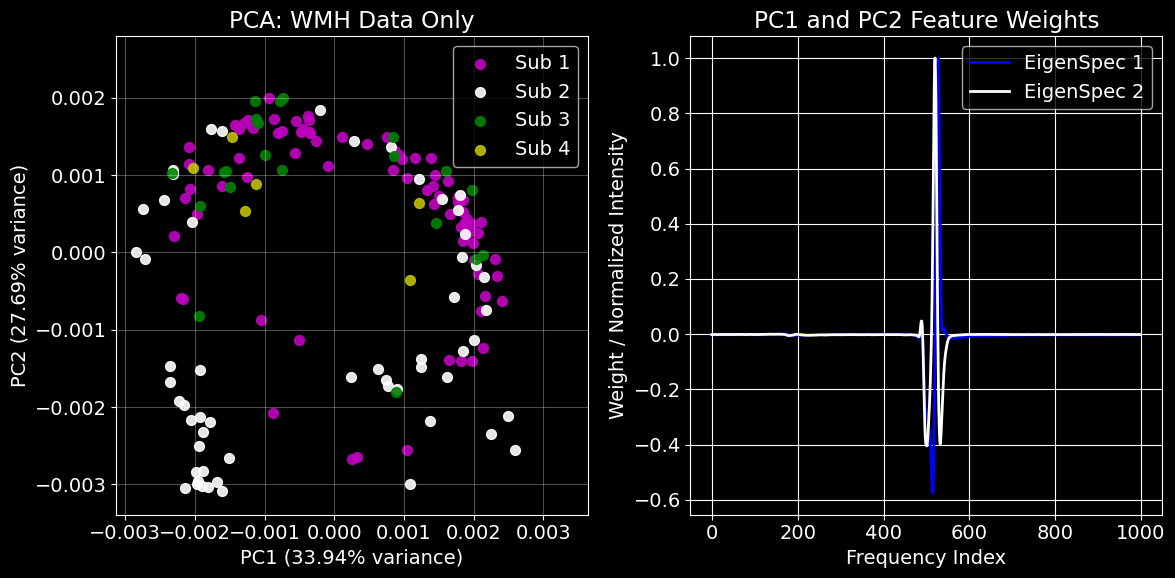

=== WMH PCA Results ===
WMH data shape: (162, 1000)
Transformed data shape: (162, 2)
PC1 explained variance: 33.94%
PC2 explained variance: 27.69%
Total variance explained: 61.63%


In [11]:
# Perform PCA with 2 components on WMH data only
pca_wmh = PCA(n_components=2)
pca_wmh_transformed = pca_wmh.fit_transform(WMH)

# Get the principal components from the WMH PCA
pca_components_wmh = pca_wmh.components_  # Shape: (2, 1000)

# Normalize each component so that the maximum absolute value is 1
for i in range(pca_components_wmh.shape[0]):
    max_abs_value = np.max(np.abs(pca_components_wmh[i, :]))
    if max_abs_value > 0:
        pca_components_wmh[i, :] = pca_components_wmh[i, :] / max_abs_value

# Create the plot
plt.figure(figsize=(12, 6))

# Define colors for each subject
colors = ['m', 'w', 'g', 'y']  # magenta, white, green, yellow
subject_names = ['Sub 1', 'Sub 2', 'Sub 3', 'Sub 4']

# Plot 1: PCA scatter plot by subject
plt.subplot(1, 2, 1)
for i in range(1, 5):
    mask = Labels == i
    plt.scatter(pca_wmh_transformed[mask, 0], 
               pca_wmh_transformed[mask, 1],
               c=colors[i-1], label=subject_names[i-1], alpha=0.9, s=50)

# Add labels and title
explained_var_1 = pca_wmh.explained_variance_ratio_[0] * 100
explained_var_2 = pca_wmh.explained_variance_ratio_[1] * 100
plt.xlabel(f'PC1 ({explained_var_1:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_var_2:.2f}% variance)')
plt.title('PCA: WMH Data Only')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(np.min(pca_wmh_transformed[:,0])*1.1, np.max(pca_wmh_transformed[:,0])*1.4)
plt.ylim(np.min(pca_wmh_transformed[:,1])*1.1, np.max(pca_wmh_transformed[:,1])*1.4)

# Plot 2: Feature weights for PC1 and PC2
plt.subplot(1, 2, 2)
plt.plot(pca_components_wmh[0, :], label=f'EigenSpec 1', linewidth=2, color='b')
plt.plot(pca_components_wmh[1, :], label=f'EigenSpec 2', linewidth=2, color='w')
plt.title('PC1 and PC2 Feature Weights')
plt.xlabel('Frequency Index')
plt.ylabel('Weight / Normalized Intensity')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary information
print("=== WMH PCA Results ===")
print(f"WMH data shape: {WMH.shape}")
print(f"Transformed data shape: {pca_wmh_transformed.shape}")
print(f"PC1 explained variance: {explained_var_1:.2f}%")
print(f"PC2 explained variance: {explained_var_2:.2f}%")
print(f"Total variance explained: {np.sum(pca_wmh.explained_variance_ratio_) * 100:.2f}%")

## Figure 4 Contrastive PCA

In [ ]:
# Create the cPCA object. All figures were based on these parameters.
mdl = CPCA(n_components=5)
projected_data = mdl.fit_transform(WMH, BACK, plot=False, 
                                  alpha_selection='manual', 
                                  alpha_value=5)

print(f"Projected data shape: {projected_data.shape}")

Projected data shape: (162, 5)


## Figure 4A: Contrastive PCA by Subject

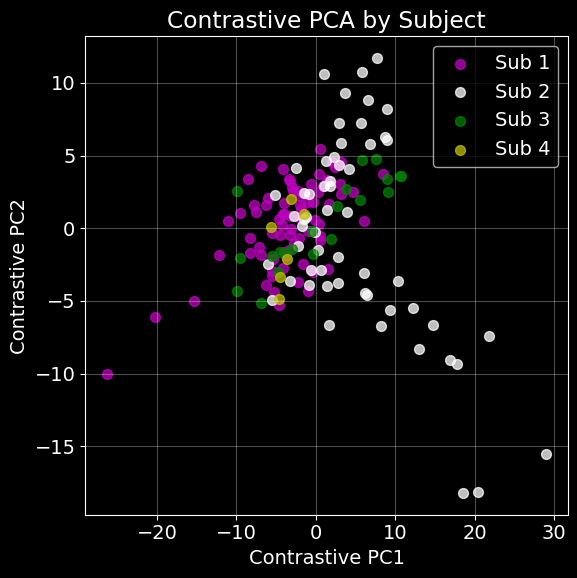

In [14]:
# Visualize projected_data colored by Labels
plt.figure(figsize=(6, 6))

# Define custom colors for the 4 subjects
colors = ['m', 'w', 'g', 'y']  # magenta, white, green, yellow

for i in range(1, 5):
    mask = Labels == i
    plt.scatter(projected_data[mask, 0], projected_data[mask, 1], 
               c=colors[i-1], label=f'Sub {i}', s=50, alpha=0.75)

plt.xlabel('Contrastive PC1')
plt.ylabel('Contrastive PC2')
plt.title('Contrastive PCA by Subject')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Figure 4B: K-means Clustering

Cluster labels shape: (162,)
Unique clusters: [0 1 2]


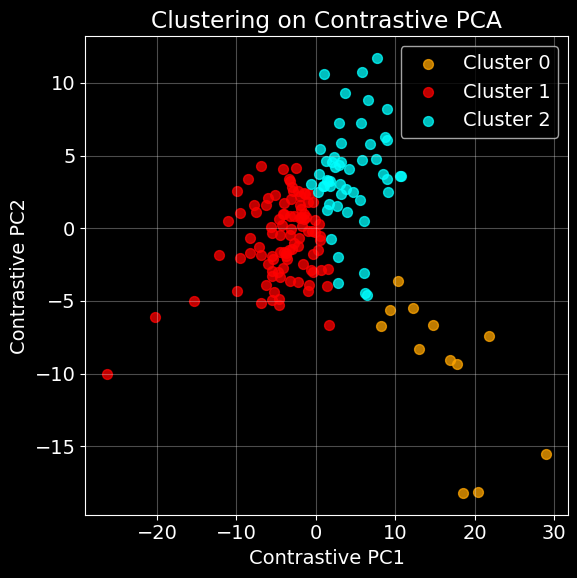

In [6]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(projected_data)

print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"Unique clusters: {np.unique(cluster_labels)}")

plt.figure(figsize=(6, 6))

colors = ['orange', 'red', 'cyan']
for i in range(n_clusters):
    mask = cluster_labels == i
    plt.scatter(projected_data[mask, 0], projected_data[mask, 1], 
               c=colors[i], label=f'Cluster {i}', s=50, alpha=0.75)

plt.xlabel('Contrastive PC1')
plt.ylabel('Contrastive PC2')
plt.title(f'Clustering on Contrastive PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Figure 4C: Clusters by Subject

Original subject labels: [1. 2. 3. 4.]
K-means cluster labels: [0 1 2]

Contingency Matrix (Clusters × Subjects):
           Subject 1  Subject 2  Subject 3  Subject 4
Cluster 0        0.0       12.0        0.0        0.0
Cluster 1       62.0       19.0       11.0        6.0
Cluster 2       16.0       26.0       10.0        0.0


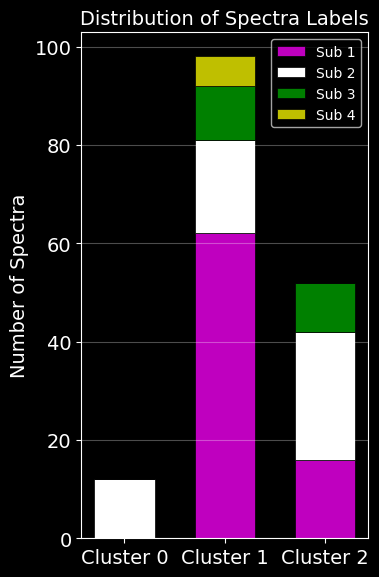


=== Cluster Composition ===

Cluster 0:
  Total samples: 12
Class1: 0 samples (0.0%)
Class2: 12 samples (100.0%)
Class3: 0 samples (0.0%)
Class4: 0 samples (0.0%)

Cluster 1:
  Total samples: 98
Class1: 62 samples (63.3%)
Class2: 19 samples (19.4%)
Class3: 11 samples (11.2%)
Class4: 6 samples (6.1%)

Cluster 2:
  Total samples: 52
Class1: 16 samples (30.8%)
Class2: 26 samples (50.0%)
Class3: 10 samples (19.2%)
Class4: 0 samples (0.0%)


In [15]:
# Create a contingency table showing the relationship between cluster_labels and Labels
from collections import Counter
import pandas as pd

# Get unique values
unique_clusters = np.unique(cluster_labels)
unique_labels = np.unique(Labels)

print(f"Original subject labels: {unique_labels}")
print(f"K-means cluster labels: {unique_clusters}")

# Create a contingency matrix
contingency_matrix = np.zeros((len(unique_clusters), len(unique_labels)))

for i, cluster in enumerate(unique_clusters):
    cluster_mask = cluster_labels == cluster
    for j, label in enumerate(unique_labels):
        # Count how many samples from patient 'label' are in cluster 'cluster'
        count = np.sum((cluster_labels == cluster) & (Labels == label))
        contingency_matrix[i, j] = count

print("\nContingency Matrix (Clusters × Subjects):")
print(pd.DataFrame(contingency_matrix, 
                   index=[f'Cluster {i}' for i in unique_clusters],
                   columns=[f'Subject {int(l)}' for l in unique_labels]))

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(4, 6))

# Set up colors for each subject
subject_colors = ['m', 'w', 'g', 'y']  # magenta, white, green, yellow
bar_width = 0.6
x_positions = np.arange(len(unique_clusters))

# Create the stacked bars
bottom = np.zeros(len(unique_clusters))
for j, label in enumerate(unique_labels):
    counts = contingency_matrix[:, j]
    ax.bar(x_positions, counts, bar_width, 
           bottom=bottom, 
           label=f'Sub {int(label)}',
           color=subject_colors[j],
           edgecolor='black',
           linewidth=0.5)
    bottom += counts

# Customize the plot
#ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Number of Spectra', fontsize=14)
ax.set_title('Distribution of Spectra Labels', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels([f'Cluster {i}' for i in unique_clusters])
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Cluster Composition ===")
for i, cluster in enumerate(unique_clusters):
    print(f"\nCluster {cluster}:")
    total = int(np.sum(contingency_matrix[i, :]))
    print(f"  Total samples: {total}")
    for j, label in enumerate(unique_labels):
        count = int(contingency_matrix[i, j])
        percentage = (count / total * 100) if total > 0 else 0
        print(f"Class{int(label)}: {count} samples ({percentage:.1f}%)")

## Figure 4D: Contrastive Eigenspectra

=== Contrastive PCA Variance Explained ===
Total positive eigenvalues sum: 41.363
Component 1: Eigenvalue = 27.593215, Explained Variance = 66.71%
Component 2: Eigenvalue = 9.230698, Explained Variance = 22.32%
Component 3: Eigenvalue = 2.666202, Explained Variance = 6.45%
Component 4: Eigenvalue = 1.873058, Explained Variance = 4.53%


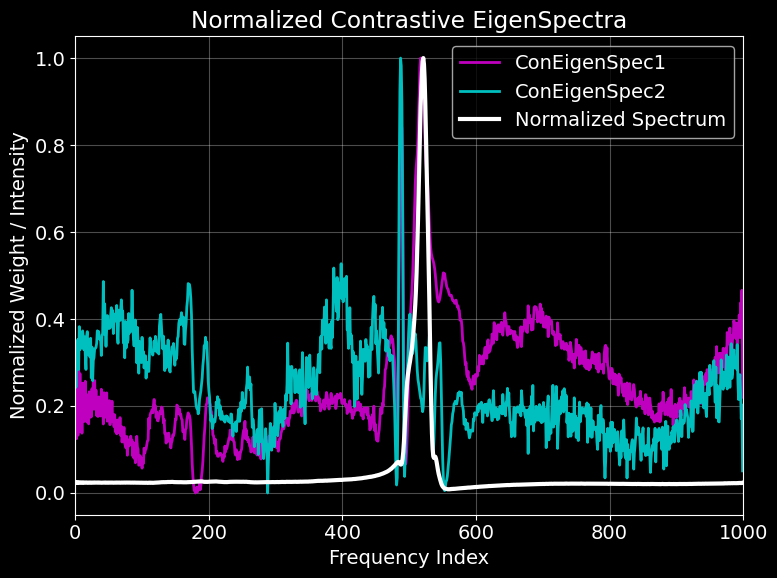

In [16]:
# After running CPCA
sigma = mdl.fg_cov - alpha * mdl.bg_cov
w, v = np.linalg.eig(sigma)  # w = eigenvalues, v = eigenvectors

# Get the contrastive components (eigenvectors)
n_components = 4
eig_idx = np.argpartition(w, -n_components)[-n_components:]
eig_idx = eig_idx[np.argsort(-w[eig_idx])]

# Extract the top contrastive components
contrastive_components = v[:, eig_idx]  # Shape: (1000, 4)
contrastive_eigenvalues = w[eig_idx]    # Shape: (4,)

# Calculate explained variance ratios
# For contrastive PCA, we use the positive eigenvalues for variance calculation
positive_eigenvalues = contrastive_eigenvalues[contrastive_eigenvalues > 0]
total_positive_variance = np.sum(positive_eigenvalues)
explained_variance_ratio = (contrastive_eigenvalues / total_positive_variance * 100) if total_positive_variance > 0 else np.zeros_like(contrastive_eigenvalues)

# Normalize the first 2 contrastive components to range [0, 1]
contrastive_comp_norm = np.zeros((contrastive_components.shape[0], 2))
for i in range(2):
    comp = contrastive_components[:, i]
    contrastive_comp_norm[:, i] = (comp - np.min(comp)) / (np.max(comp) - np.min(comp))

# Print summary of explained variance
print("=== Contrastive PCA Variance Explained ===")
print(f"Total positive eigenvalues sum: {total_positive_variance:.3f}")
for i in range(n_components):
    eigenval = contrastive_eigenvalues[i]
    explained_var = explained_variance_ratio[i] if eigenval > 0 else 0
    print(f"Component {i+1}: Eigenvalue = {eigenval:.6f}, Explained Variance = {explained_var:.2f}%")

# Plot the first 2 normalized contrastive components on the same plot
plt.figure(figsize=(8, 6))

plt.plot(contrastive_comp_norm[:, 0], label=f'ConEigenSpec1', linewidth=2, color='m')
plt.plot(contrastive_comp_norm[:, 1], label=f'ConEigenSpec2', linewidth=2, color='c')
plt.plot(WMH_mean/ np.max(WMH_mean), label='Normalized Spectrum', alpha=1, color='w', linewidth=3)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)

plt.title('Normalized Contrastive EigenSpectra')
plt.xlabel('Frequency Index')
plt.ylabel('Normalized Weight / Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Figure 4E,F: Cluster Mean Spectra

=== Calculating Mean Spectra for Each Cluster ===
Cluster 0: 12 samples
Cluster 1: 98 samples
Cluster 2: 52 samples


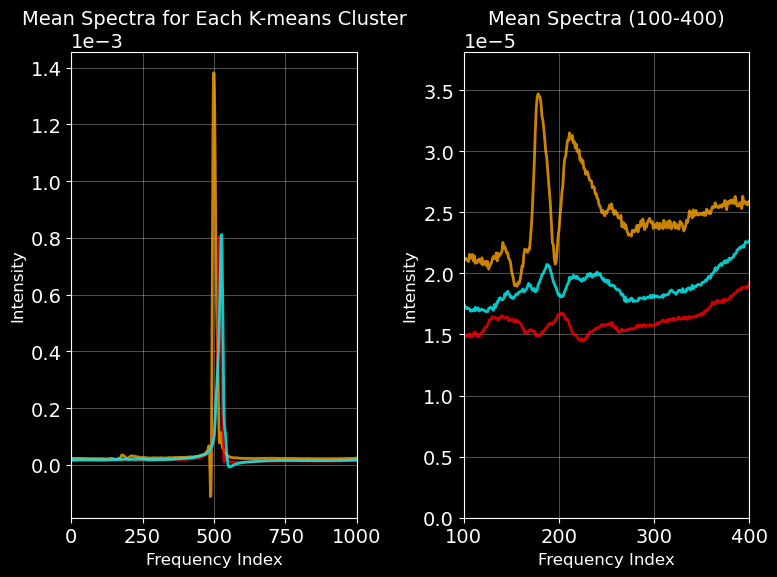

In [7]:
cluster_mean_spectra = []

print("=== Calculating Mean Spectra for Each Cluster ===")
for i in range(n_clusters):
    mask = cluster_labels == i
    cluster_data = WMH[mask]
    mean_spectrum = np.mean(cluster_data, axis=0)
    cluster_mean_spectra.append(mean_spectrum)
    print(f"Cluster {i}: {np.sum(mask)} samples")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

cluster_colors = ['orange', 'red', 'cyan']

for i in range(n_clusters):
    ax1.plot(cluster_mean_spectra[i], 
             label=f'Cluster {i} (n={np.sum(cluster_labels == i)})', 
             color=cluster_colors[i], 
             linewidth=2, 
             alpha=0.8)

ax1.set_title('Mean Spectra for Each K-means Cluster', fontsize=14)
ax1.set_xlabel('Frequency Index', fontsize=12)
ax1.set_ylabel('Intensity', fontsize=12)
ax1.set_xlim(0, 1000)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for i in range(n_clusters):
    ax2.plot(cluster_mean_spectra[i], 
             label=f'Cluster {i} (n={np.sum(cluster_labels == i)})', 
             color=cluster_colors[i], 
             linewidth=2, 
             alpha=0.8)

ax2.set_title('Mean Spectra (100-400)', fontsize=14)
ax2.set_xlabel('Frequency Index', fontsize=12)
ax2.set_ylabel('Intensity', fontsize=12)
ax2.set_xlim(100, 400)
ax2.set_ylim(0, np.max([np.max(spec[100:400]) for spec in cluster_mean_spectra]) * 1.1)
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()